# Python Assignment

#### Information on the work:

This work was done by:
    - Charles PAYET
    - Lucas OLIVIER
    - Kaveh JALILIAN
    - Xuejie MA
    - Sébastien PAVOT

Bellow, you will find the code that made possible to predict the donation of more or equal to 35€. 
All the code is commented in order to make it understandable. Nearly all the code is automatized so you shouldn't do anything to make it run (only changing path for data files).
Futhermore, we would like you to first look at the output already given, as we used a lot of variables and some nested loop, the code take more than 30 minutes to run. 
Thanks in advance for the time you will spend on our work.
Yours faithfully,
Team.


### Packages

In [ ]:
import sys

import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score
from sklearn.metrics        import accuracy_score
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from scipy.stats.mstats   import winsorize
from numpy                import array
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

#### Local path

In [ ]:
sys.path.append("/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data")

#### Local libaries

In [3]:
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

In [4]:
directory = "/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Assigment"
inputData = directory + "/Data"

## 1) Project Definition

#### Create a model to predict which candidate donators are most likely to donate again at least 35€

## 2) Data preparation

#### A) Read the data:

In [5]:
donors = pd.read_csv(inputData + "/donors.csv", sep = ';')

In [6]:
donors.head()

,donorID,gender,language,zipcode,region
0,100001,M,N,1861,Missing
1,100002,M,F,2260,13049A090
2,100003,M,F,1780,21004A24-
3,100004,M,N,1020,Missing
4,100005,F,F,1020,21004F522


In [7]:
gifts = pd.read_csv(inputData + "/gifts.csv", sep = ";")

In [8]:
gifts.head()

,campID,donorID,amount,date
0,0,100001,12.39,23/10/1998
1,1577,100001,12.39,18/08/1999
2,1634,100001,6.69,31/12/1999
3,1778,100001,24.79,19/10/2000
4,1808,100001,7.44,29/12/2000


#### B) Inspect the data : Donors

In [9]:
donors.max()

donorID      144691
gender            U
language          N
region      Missing
dtype: object

In [10]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 5 columns):
donorID     44691 non-null int64
gender      44691 non-null object
language    44691 non-null object
zipcode     44690 non-null object
region      44691 non-null object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [11]:
for (index,column) in enumerate(donors.columns):
    print(f"Column {index}: {column}")
    print(donors[column].nunique())


Column 0: donorID
44691
Column 1: gender
5
Column 2: language
2
Column 3: zipcode
1025
Column 4: region
4760


In [12]:
donors.isna().sum()

donorID     0
gender      0
language    0
zipcode     1
region      0
dtype: int64

#### Now that we've inspected the data, we can say :

Gender --> Transform into dummy encoding 
Language --> Transform into dummy encoding
Zipcode --> Already a number, no change needed
Region --> Fix missing values & transform into dummy encoding

#### B) Inspect the data : Gifts

In [13]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215042 entries, 0 to 215041
Data columns (total 4 columns):
campID     215042 non-null int64
donorID    215042 non-null int64
amount     215042 non-null float64
date       215042 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 6.6+ MB


In [14]:
gifts.max()

campID          7536
donorID       144691
amount       12394.7
date       9/12/2013
dtype: object

In [15]:
for (index,column) in enumerate(gifts.columns):
    print(f"Column {index}: {column}")
    print(gifts[column].nunique())


Column 0: campID
366
Column 1: donorID
44686
Column 2: amount
954
Column 3: date
5407


In [16]:
gifts.isna().sum()

campID     0
donorID    0
amount     0
date       0
dtype: int64

#### Transformation needed for gifts data:

campID --> Already a number, no need to change
Amount --> Alreayd use "." as separator for decimals, already a float, no need change
Date --> Is an object, need to transform to date 
#### Columns to adds
target --> donation is equal or superior to 35€
nbr_donation --> count the number the donor gave
avg_donation --> average amount gave per donor
last_donation --> time since last donation 
sum_donation ---> sum amount gave per donor
nbr_campaings --> number of campaings the donor was targeted by
More columns are also added bellow

### Data Preparation : Donors

### Nominal variables & missing values

#### Gender : Transform into dummy encoding

In [17]:
donors = donors.join(pd.get_dummies(donors['gender'], prefix = 'Is_', drop_first = False))

In [18]:
donors.head()

,donorID,gender,language,zipcode,region,Is__C,Is__F,Is__M,Is__S,Is__U
0,100001,M,N,1861,Missing,0,0,1,0,0
1,100002,M,F,2260,13049A090,0,0,1,0,0
2,100003,M,F,1780,21004A24-,0,0,1,0,0
3,100004,M,N,1020,Missing,0,0,1,0,0
4,100005,F,F,1020,21004F522,0,1,0,0,0


In [19]:
donors = donors.drop(columns=['gender','Is__F'])

In [20]:
donors.head()

,donorID,language,zipcode,region,Is__C,Is__M,Is__S,Is__U
0,100001,N,1861,Missing,0,1,0,0
1,100002,F,2260,13049A090,0,1,0,0
2,100003,F,1780,21004A24-,0,1,0,0
3,100004,N,1020,Missing,0,1,0,0
4,100005,F,1020,21004F522,0,0,0,0


#### Language: Transform into dummy encoding

In [21]:
donors.loc[donors['language'] == 'N', 'language'] = "Dutch"

In [22]:
donors.loc[donors['language'] == 'F', 'language'] = "French"

In [23]:
donors.head()

,donorID,language,zipcode,region,Is__C,Is__M,Is__S,Is__U
0,100001,Dutch,1861,Missing,0,1,0,0
1,100002,French,2260,13049A090,0,1,0,0
2,100003,French,1780,21004A24-,0,1,0,0
3,100004,Dutch,1020,Missing,0,1,0,0
4,100005,French,1020,21004F522,0,0,0,0


In [24]:
donors = donors.join(pd.get_dummies(donors["language"], prefix = "Is_", drop_first = True))

In [25]:
donors = donors.drop(columns=["language"])

In [26]:
donors.head()

,donorID,zipcode,region,Is__C,Is__M,Is__S,Is__U,Is__French
0,100001,1861,Missing,0,1,0,0,0
1,100002,2260,13049A090,0,1,0,0,1
2,100003,1780,21004A24-,0,1,0,0,1
3,100004,1020,Missing,0,1,0,0,0
4,100005,1020,21004F522,0,0,0,0,1


#### Region: Fix missing values & transform into dummy encoding

In order to fix the region, we downloaded a csv file with zipcode and the region associated to it.
The data is available here (opensource data): https://public.opendatasoft.com/explore/dataset/liste-des-codes-postaux-belges-fr/table/?refine.sous_commune=Non
We will use this data to do an inner join between this data and the donors data in order to replace the region column by a new column with the right region. As there's a lot of missing value in region, we add this new column to fix the region data.

In [27]:
postal_code =  pd.read_csv(inputData + "/postal_code_belgium.csv", sep = ';')

In [28]:
postal_code.head()

,Code postal,Localité,Sous-commune,Commune principale,Province
0,9700,Melden,Oui,OUDENAARDE,Flandre-Orientale
1,1160,AUDERGHEM,Non,AUDERGHEM,Bruxelles (19 communes)
2,9630,Dikkele,Oui,ZWALM,Flandre-Orientale
3,8480,Eernegem,Oui,ICHTEGEM,Flandre-Occidentale
4,3800,Groot-Gelmen,Oui,SINT-TRUIDEN,Limbourg


We now delete "localité","sous-commune","Commune principale" because we don't want that data and only keep "Province" and "Code Postal"
"Code postal" will be the column used to do the inner join with donors file

In [29]:
postal_code = postal_code.drop(columns = ['Localité'])

In [30]:
postal_code = postal_code.drop(columns = ['Commune principale'])

In [31]:
postal_code = postal_code.drop(columns = ['Sous-commune'])

In [32]:
postal_code.head()

,Code postal,Province
0,9700,Flandre-Orientale
1,1160,Bruxelles (19 communes)
2,9630,Flandre-Orientale
3,8480,Flandre-Occidentale
4,3800,Limbourg


In [33]:
postal_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2825 entries, 0 to 2824
Data columns (total 2 columns):
Code postal    2825 non-null int64
Province       2781 non-null object
dtypes: int64(1), object(1)
memory usage: 44.2+ KB


We have some duplicates Code Postal in this database, we're going to remove duplicates just bellow to make sure when we will do the inner join it won't create duplicate 

We now have only the columns wanted, now we will do an inner join with the donors data

In [34]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 8 columns):
donorID       44691 non-null int64
zipcode       44690 non-null object
region        44691 non-null object
Is__C         44691 non-null uint8
Is__M         44691 non-null uint8
Is__S         44691 non-null uint8
Is__U         44691 non-null uint8
Is__French    44691 non-null uint8
dtypes: int64(1), object(2), uint8(5)
memory usage: 1.2+ MB


We now check if Code postal is also an integer before doing the inner join

In [35]:
postal_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2825 entries, 0 to 2824
Data columns (total 2 columns):
Code postal    2825 non-null int64
Province       2781 non-null object
dtypes: int64(1), object(1)
memory usage: 44.2+ KB


We don't need to change the type of code postal but we need to rename Code postal to delete the space to make sure we can use it with the inner join with pysqldf

In [36]:
postal_code = postal_code.rename(columns = {'Code postal' :'code_postal'})

In [37]:
postal_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2825 entries, 0 to 2824
Data columns (total 2 columns):
code_postal    2825 non-null int64
Province       2781 non-null object
dtypes: int64(1), object(1)
memory usage: 44.2+ KB


Before doing the inner join, we remove duplicates values in postal_code. As some postal code are repeated twice or more, it will generate duplicates values when doing the inner join, so we remove them before.

In [38]:
postal_code.drop_duplicates(subset ="code_postal", 
                     keep = 'first', inplace = True)

In [39]:
postal_code.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190 entries, 0 to 2822
Data columns (total 2 columns):
code_postal    1190 non-null int64
Province       1146 non-null object
dtypes: int64(1), object(1)
memory usage: 27.9+ KB


Now, we're doing an inner join to have our new dataframe donors2 on the matching values of zipcode and Code postal

In [40]:
donors2 = pysqldf ("""
SELECT *
FROM donors d1
INNER JOIN postal_code p2
ON d1.zipcode = p2.code_postal
""")

In [41]:
donors2.head()

,donorID,zipcode,region,Is__C,Is__M,Is__S,Is__U,Is__French,code_postal,Province
0,100001,1861,Missing,0,1,0,0,0,1861,Brabant Flamand
1,100002,2260,13049A090,0,1,0,0,1,2260,Anvers
2,100003,1780,21004A24-,0,1,0,0,1,1780,Brabant Flamand
3,100004,1020,Missing,0,1,0,0,0,1020,Bruxelles (19 communes)
4,100005,1020,21004F522,0,0,0,0,1,1020,Bruxelles (19 communes)


In [42]:
donors2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44687 entries, 0 to 44686
Data columns (total 10 columns):
donorID        44687 non-null int64
zipcode        44687 non-null object
region         44687 non-null object
Is__C          44687 non-null int64
Is__M          44687 non-null int64
Is__S          44687 non-null int64
Is__U          44687 non-null int64
Is__French     44687 non-null int64
code_postal    44687 non-null int64
Province       44687 non-null object
dtypes: int64(7), object(3)
memory usage: 3.4+ MB


In [43]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 8 columns):
donorID       44691 non-null int64
zipcode       44690 non-null object
region        44691 non-null object
Is__C         44691 non-null uint8
Is__M         44691 non-null uint8
Is__S         44691 non-null uint8
Is__U         44691 non-null uint8
Is__French    44691 non-null uint8
dtypes: int64(1), object(2), uint8(5)
memory usage: 1.2+ MB


We can see that we lost 4 entries, maybe because the postal code was not in the list that we had, it's an acceptable loss regarding that we nearly have 50 thousand entries

Now, we have to remove code_postal and region columns which are useless 

In [44]:
donors2 = donors2.drop(columns=["region"])

In [45]:
donors2 = donors2.drop(columns=["code_postal"])

In [46]:
donors2.head()

,donorID,zipcode,Is__C,Is__M,Is__S,Is__U,Is__French,Province
0,100001,1861,0,1,0,0,0,Brabant Flamand
1,100002,2260,0,1,0,0,1,Anvers
2,100003,1780,0,1,0,0,1,Brabant Flamand
3,100004,1020,0,1,0,0,0,Bruxelles (19 communes)
4,100005,1020,0,0,0,0,1,Bruxelles (19 communes)


In [47]:
donors2['Province'].unique()

array(['Brabant Flamand', 'Anvers', 'Bruxelles (19 communes)',
       'Brabant Wallon', 'Flandre-Occidentale', 'Flandre-Orientale',
       'Liège', 'Luxembourg', 'Namur', 'Hainaut', 'Limbourg'],
      dtype=object)

We will now rename Bruxelles (19 communes) to Bruxelles and after doing a dummy encoding

In [48]:
donors2.loc[donors2['Province'] == 'Bruxelles (19 communes)', 'Province'] = "Bruxelles"

In [49]:
donors2.head()

,donorID,zipcode,Is__C,Is__M,Is__S,Is__U,Is__French,Province
0,100001,1861,0,1,0,0,0,Brabant Flamand
1,100002,2260,0,1,0,0,1,Anvers
2,100003,1780,0,1,0,0,1,Brabant Flamand
3,100004,1020,0,1,0,0,0,Bruxelles
4,100005,1020,0,0,0,0,1,Bruxelles


Now, we've going to do the dummy encoding:

In [50]:
donors2 = donors2.join(pd.get_dummies(donors2["Province"], prefix = "Is_in_", drop_first = True))

In [51]:
donors2 = donors2.drop(columns = ['Province'])

In [52]:
donors2.head()

,donorID,zipcode,Is__C,Is__M,Is__S,Is__U,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,Is_in__Flandre-Orientale,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur
0,100001,1861,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,100002,2260,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,100003,1780,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
3,100004,1020,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,100005,1020,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


Switch the type of zipcode into integer and everything is good

In [53]:
donors2.zipcode = donors2.zipcode.astype(int)

In [54]:
donors2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44687 entries, 0 to 44686
Data columns (total 17 columns):
donorID                       44687 non-null int64
zipcode                       44687 non-null int32
Is__C                         44687 non-null int64
Is__M                         44687 non-null int64
Is__S                         44687 non-null int64
Is__U                         44687 non-null int64
Is__French                    44687 non-null int64
Is_in__Brabant Flamand        44687 non-null uint8
Is_in__Brabant Wallon         44687 non-null uint8
Is_in__Bruxelles              44687 non-null uint8
Is_in__Flandre-Occidentale    44687 non-null uint8
Is_in__Flandre-Orientale      44687 non-null uint8
Is_in__Hainaut                44687 non-null uint8
Is_in__Limbourg               44687 non-null uint8
Is_in__Liège                  44687 non-null uint8
Is_in__Luxembourg             44687 non-null uint8
Is_in__Namur                  44687 non-null uint8
dtypes: int32(1), int64(

We add a second document, dist_brux.csv which give us the distance between different cities and Bruxelles in km

In [55]:
distance_brux =  pd.read_csv(inputData + "/dist_brux.csv", encoding='latin-1', decimal = ',')

In [56]:
distance_brux.head()

,ZIP Code,City,Adresse d'arrivée,Distance Km
0,1005,1005 Assemblée Réunie de la Commission Communa...,BRUXELLES,0.0
1,1011,"1011 Vlaams parlement, Belgique",BRUXELLES,0.0
2,1030,"1030 SCHAERBEEK, Belgique",BRUXELLES,0.0
3,1031,"1031 Organisations Sociales Chrétiennes, Belgique",BRUXELLES,0.0
4,1047,"1047 Parlement Européen, Belgique",BRUXELLES,0.0


We drop useless columns

In [57]:
distance_brux = distance_brux.drop(columns = ['City'])

In [58]:
distance_brux = distance_brux.drop(columns = ["Adresse d'arrivée"])

In [59]:
distance_brux.head()

,ZIP Code,Distance Km
0,1005,0.0
1,1011,0.0
2,1030,0.0
3,1031,0.0
4,1047,0.0


We merge donors2 with dist_brux on zipcode

In [60]:
donors2 = pd.merge(donors2, distance_brux, how = "left",
                            left_on = "zipcode", right_on = "ZIP Code")

In [61]:
donors2 = donors2.drop(columns = ["ZIP Code"])

In [62]:
donors2 = donors2.rename(columns = {'Distance Km' :'distance_km'})

In [63]:
donors2.head()

,donorID,zipcode,Is__C,Is__M,Is__S,Is__U,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,Is_in__Flandre-Orientale,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur,distance_km
0,100001,1861,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,13.30
1,100002,2260,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,6.00
2,100003,1780,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,11.92
3,100004,1020,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,4.34
4,100005,1020,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,4.34


In [64]:
donors2.isna().sum()

donorID                       0
zipcode                       0
Is__C                         0
Is__M                         0
Is__S                         0
Is__U                         0
Is__French                    0
Is_in__Brabant Flamand        0
Is_in__Brabant Wallon         0
Is_in__Bruxelles              0
Is_in__Flandre-Occidentale    0
Is_in__Flandre-Orientale      0
Is_in__Hainaut                0
Is_in__Limbourg               0
Is_in__Liège                  0
Is_in__Luxembourg             0
Is_in__Namur                  0
distance_km                   0
dtype: int64

In [65]:
donors2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44687 entries, 0 to 44686
Data columns (total 18 columns):
donorID                       44687 non-null int64
zipcode                       44687 non-null int32
Is__C                         44687 non-null int64
Is__M                         44687 non-null int64
Is__S                         44687 non-null int64
Is__U                         44687 non-null int64
Is__French                    44687 non-null int64
Is_in__Brabant Flamand        44687 non-null uint8
Is_in__Brabant Wallon         44687 non-null uint8
Is_in__Bruxelles              44687 non-null uint8
Is_in__Flandre-Occidentale    44687 non-null uint8
Is_in__Flandre-Orientale      44687 non-null uint8
Is_in__Hainaut                44687 non-null uint8
Is_in__Limbourg               44687 non-null uint8
Is_in__Liège                  44687 non-null uint8
Is_in__Luxembourg             44687 non-null uint8
Is_in__Namur                  44687 non-null uint8
distance_km             

We convert distance_km into a float to make it available for computing

In [66]:
donors2['distance_km'] = pd.to_numeric(donors2['distance_km'],errors='coerce')

In [67]:
donors2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44687 entries, 0 to 44686
Data columns (total 18 columns):
donorID                       44687 non-null int64
zipcode                       44687 non-null int32
Is__C                         44687 non-null int64
Is__M                         44687 non-null int64
Is__S                         44687 non-null int64
Is__U                         44687 non-null int64
Is__French                    44687 non-null int64
Is_in__Brabant Flamand        44687 non-null uint8
Is_in__Brabant Wallon         44687 non-null uint8
Is_in__Bruxelles              44687 non-null uint8
Is_in__Flandre-Occidentale    44687 non-null uint8
Is_in__Flandre-Orientale      44687 non-null uint8
Is_in__Hainaut                44687 non-null uint8
Is_in__Limbourg               44687 non-null uint8
Is_in__Liège                  44687 non-null uint8
Is_in__Luxembourg             44687 non-null uint8
Is_in__Namur                  44687 non-null uint8
distance_km             

### Data Preparation : Campaign

It's our target, we need to add a column with value 1 if the donation is above or equal 35€ and 0 else.
We need first to import the training set and the test set and add them the column target.

In [68]:
trainingSet = pd.read_csv(inputData + "/campaign20130411.csv", sep = ';')

In [69]:
testSet = pd.read_csv(inputData + "/campaign20140115.csv", sep = ';')

In [70]:
trainingSet['target'] = (trainingSet['amount'] >= 35)*1

In [71]:
trainingSet.head()

,donorID,amount,target
0,100001,0.0,0
1,100002,0.0,0
2,100004,0.0,0
3,100008,0.0,0
4,100009,0.0,0


In [72]:
trainingSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34917 entries, 0 to 34916
Data columns (total 3 columns):
donorID    34917 non-null int64
amount     34917 non-null float64
target     34917 non-null int32
dtypes: float64(1), int32(1), int64(1)
memory usage: 682.1 KB


In [73]:
testSet['target'] = (testSet['amount'] >= 35)*1

In [74]:
testSet.head()

,donorID,amount,target
0,100001,0.0,0
1,100002,0.0,0
2,100008,0.0,0
3,100009,0.0,0
4,100010,0.0,0


### Data Preparation : Gifts

In [75]:
gifts.head()

,campID,donorID,amount,date
0,0,100001,12.39,23/10/1998
1,1577,100001,12.39,18/08/1999
2,1634,100001,6.69,31/12/1999
3,1778,100001,24.79,19/10/2000
4,1808,100001,7.44,29/12/2000


We need to change the data in order to have only one row per donors to make sure that we can do a good inner join with our donors2 data and also the training and test set.
So we will change the column to create new ones representating the donors

### Columns to adds


#### nbr_donation --> count the number of times the donor gave


As we have some data that are after the date of the trainingSet in the Gift data, we're going to create featuresTest which will contains all the data because there's no future data. featuresTraining will contain only data before 01/04/2013 to make sure we don't cheat using data to train that are after the training date data.

In [76]:
featuresTest = pd.DataFrame()

In [77]:
featuresTest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

We create donorID as a column in features which is equal to the index

In [78]:
featuresTest['donorID'] = featuresTest.index


Now we groupby donorID and count the number of times amount appears per donor

In [79]:
featuresTest['count_total'] = gifts.groupby(['donorID'])['amount'].agg('count')

We also create a column to count number of times the donors gave if it was a campaign (campID != 0)

In [80]:
featuresTest['count_non_0'] = gifts[gifts["campID"] != 0].groupby(['donorID'])['amount'].agg('count')


And the same for the number of times he did when it wasn't a campaign

In [81]:
featuresTest['count_0'] = featuresTest['count_total'] - featuresTest['count_non_0']

In [82]:
featuresTest.head()

,donorID,count_total,count_non_0,count_0
donorID,,,,
100001,NaN,12,11.0,1.0
100002,NaN,1,1.0,0.0
100003,NaN,12,12.0,0.0
100004,NaN,26,25.0,1.0
100005,NaN,5,5.0,0.0


#### sum_donation ---> sum amount gave per donor


As above, group by donor but this time we do the sum of amount given

In [83]:
featuresTest['sum'] = gifts.groupby(['donorID'])['amount'].sum()

In [84]:
featuresTest.head()

,donorID,count_total,count_non_0,count_0,sum
donorID,,,,,
100001,NaN,12,11.0,1.0,178.49
100002,NaN,1,1.0,0.0,20.00
100003,NaN,12,12.0,0.0,46.00
100004,NaN,26,25.0,1.0,716.22
100005,NaN,5,5.0,0.0,24.96


Now, we do this for donation which come from a campaign

In [85]:
featuresTest['Sum_targeted'] = gifts[gifts["campID"] != 0].groupby(['donorID'])['amount'].sum()

And for those which doesn't

In [86]:
featuresTest['Sum_not_targeted'] = featuresTest['sum'] - featuresTest['Sum_targeted']

In [87]:
featuresTest.head()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted
donorID,,,,,,,
100001,NaN,12,11.0,1.0,178.49,166.10,12.39
100002,NaN,1,1.0,0.0,20.00,20.00,0.00
100003,NaN,12,12.0,0.0,46.00,46.00,0.00
100004,NaN,26,25.0,1.0,716.22,691.43,24.79
100005,NaN,5,5.0,0.0,24.96,24.96,0.00


#### avg_donation --> average amount gave per donor


Now, we want to do the same but for the average donation

Notice that for now, donorID = NaN, it will be fixed at the end of the data preparation for gifts, no need to worry

In [88]:
featuresTest['mean'] = gifts.groupby(['donorID'])['amount'].mean()

In [89]:
featuresTest['mean_targeted'] = gifts[gifts["campID"] != 0].groupby(['donorID'])['amount'].mean()

In [90]:
featuresTest['mean_non_targeted'] = gifts[gifts["campID"] == 0].groupby(['donorID'])['amount'].mean()

As above, we've done the general mean, and mean per campaign and non campaign

In [91]:
featuresTest.head()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted
donorID,,,,,,,,,,
100001,NaN,12,11.0,1.0,178.49,166.10,12.39,14.874167,15.100000,12.39
100002,NaN,1,1.0,0.0,20.00,20.00,0.00,20.000000,20.000000,NaN
100003,NaN,12,12.0,0.0,46.00,46.00,0.00,3.833333,3.833333,NaN
100004,NaN,26,25.0,1.0,716.22,691.43,24.79,27.546923,27.657200,24.79
100005,NaN,5,5.0,0.0,24.96,24.96,0.00,4.992000,4.992000,NaN


Notice that for the average, it creates NaN value for the donors who never gave without a campaign, we will fix those value bellow

#### last_donation --> time since last donation 


We create a column with the date 01/01/2015 which will be our reference date to calculate the days since last donation

In [92]:
gifts['today'] ='01/01/2015'

We create a column which contains the date 01/04/2013. We're going to use this to remove all date in the trainingFeatures that are after this date.

In [93]:
gifts['camp2013_date'] ='01/04/2013'

We change the new columns and date to date format

In [94]:
gifts['today'] = pd.to_datetime(gifts['today'])


In [95]:
gifts['camp2013_date'] = pd.to_datetime(gifts['camp2013_date'])

In [96]:
gifts['date'] = pd.to_datetime(gifts['date'])


In [97]:
gifts.head()

,campID,donorID,amount,date,today,camp2013_date
0,0,100001,12.39,1998-10-23,2015-01-01,2013-01-04
1,1577,100001,12.39,1999-08-18,2015-01-01,2013-01-04
2,1634,100001,6.69,1999-12-31,2015-01-01,2013-01-04
3,1778,100001,24.79,2000-10-19,2015-01-01,2013-01-04
4,1808,100001,7.44,2000-12-29,2015-01-01,2013-01-04


In [98]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215042 entries, 0 to 215041
Data columns (total 6 columns):
campID           215042 non-null int64
donorID          215042 non-null int64
amount           215042 non-null float64
date             215042 non-null datetime64[ns]
today            215042 non-null datetime64[ns]
camp2013_date    215042 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(2)
memory usage: 9.8 MB


We create a new column Difference from 2015 which represents the number of days from the date we define and the date of the donation

In [99]:
gifts['Difference_from_2015'] = gifts['today'] - gifts['date']

We do the same from 2013 to use this column to remove date after 2013. If the difference is negative, so it's meaning it's data from the future and we don't want to use it in our trainingSet

In [100]:
gifts['Difference_from_camp2013'] = gifts['camp2013_date'] - gifts['date']

In [101]:
gifts.head()

,campID,donorID,amount,date,today,camp2013_date,Difference_from_2015,Difference_from_camp2013
0,0,100001,12.39,1998-10-23,2015-01-01,2013-01-04,5914 days,5187 days
1,1577,100001,12.39,1999-08-18,2015-01-01,2013-01-04,5615 days,4888 days
2,1634,100001,6.69,1999-12-31,2015-01-01,2013-01-04,5480 days,4753 days
3,1778,100001,24.79,2000-10-19,2015-01-01,2013-01-04,5187 days,4460 days
4,1808,100001,7.44,2000-12-29,2015-01-01,2013-01-04,5116 days,4389 days


We change the type of difference into integer

In [102]:
gifts['Difference_from_2015'] = gifts['Difference_from_2015'].dt.days

In [103]:
gifts['Difference_from_camp2013'] = gifts['Difference_from_camp2013'].dt.days

In [104]:
gifts.isna().sum()

campID                      0
donorID                     0
amount                      0
date                        0
today                       0
camp2013_date               0
Difference_from_2015        0
Difference_from_camp2013    0
dtype: int64

We now create min_diff which is the minimum of days difference per donorID, this basically represents the days since the last donation as it will have the lowest number of days of difference

In [105]:
min_diff = gifts.groupby(['donorID'])['Difference_from_2015'].min()

In [106]:
min_diff.head()

donorID
100001    2936
100002    1580
100003     274
100004    3300
100005     434
Name: Difference_from_2015, dtype: int64

We now assign min_diff to a new column in features

In [107]:
featuresTest['time_last_gave'] = min_diff

In [108]:
featuresTest.head()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave
donorID,,,,,,,,,,,
100001,NaN,12,11.0,1.0,178.49,166.10,12.39,14.874167,15.100000,12.39,2936
100002,NaN,1,1.0,0.0,20.00,20.00,0.00,20.000000,20.000000,NaN,1580
100003,NaN,12,12.0,0.0,46.00,46.00,0.00,3.833333,3.833333,NaN,274
100004,NaN,26,25.0,1.0,716.22,691.43,24.79,27.546923,27.657200,24.79,3300
100005,NaN,5,5.0,0.0,24.96,24.96,0.00,4.992000,4.992000,NaN,434


In [109]:
featuresTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 100001 to 144691
Data columns (total 11 columns):
donorID              0 non-null object
count_total          44686 non-null int64
count_non_0          43406 non-null float64
count_0              43406 non-null float64
sum                  44686 non-null float64
Sum_targeted         43406 non-null float64
Sum_not_targeted     43406 non-null float64
mean                 44686 non-null float64
mean_targeted        43406 non-null float64
mean_non_targeted    5813 non-null float64
time_last_gave       44686 non-null int64
dtypes: float64(8), int64(2), object(1)
memory usage: 4.1+ MB


#### Targeted by at least one campaign (dummy encoding)

We first create a new column in gifts were we want to assign 0 if campID equal 0 and else 1

In [110]:
gifts['campaign'] = (gifts['campID'] != 0)*1

In [111]:
gifts.head()

,campID,donorID,amount,date,today,camp2013_date,Difference_from_2015,Difference_from_camp2013,campaign
0,0,100001,12.39,1998-10-23,2015-01-01,2013-01-04,5914,5187,0
1,1577,100001,12.39,1999-08-18,2015-01-01,2013-01-04,5615,4888,1
2,1634,100001,6.69,1999-12-31,2015-01-01,2013-01-04,5480,4753,1
3,1778,100001,24.79,2000-10-19,2015-01-01,2013-01-04,5187,4460,1
4,1808,100001,7.44,2000-12-29,2015-01-01,2013-01-04,5116,4389,1


Then, we group by gifts on donorID and we do a sum of our new column campaign and assign the result to targeted in features

In [112]:
featuresTest['targeted'] = gifts.groupby(['donorID'])['campaign'].sum()


In [113]:
featuresTest.head()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
donorID,,,,,,,,,,,,
100001,NaN,12,11.0,1.0,178.49,166.10,12.39,14.874167,15.100000,12.39,2936,11
100002,NaN,1,1.0,0.0,20.00,20.00,0.00,20.000000,20.000000,NaN,1580,1
100003,NaN,12,12.0,0.0,46.00,46.00,0.00,3.833333,3.833333,NaN,274,12
100004,NaN,26,25.0,1.0,716.22,691.43,24.79,27.546923,27.657200,24.79,3300,25
100005,NaN,5,5.0,0.0,24.96,24.96,0.00,4.992000,4.992000,NaN,434,5


Now, we replace all values above 1 by 1 to make sure that 0 corresponds to a donor never targeted by campaign and 1 to a donor targeted by at least 1 campaign

In [114]:
featuresTest.loc[featuresTest['targeted'] >= 1, 'targeted'] = 1

In [115]:
featuresTest.nunique()

donorID                  0
count_total            134
count_non_0            105
count_0                 83
sum                   9090
Sum_targeted          8667
Sum_not_targeted      1020
mean                 10882
mean_targeted        10355
mean_non_targeted      804
time_last_gave        4384
targeted                 2
dtype: int64

We can see above that targeted has only 2 differents values which means that it can be only 0 or 1 so we will encoded it into dummies

In [116]:
featuresTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 100001 to 144691
Data columns (total 12 columns):
donorID              0 non-null object
count_total          44686 non-null int64
count_non_0          43406 non-null float64
count_0              43406 non-null float64
sum                  44686 non-null float64
Sum_targeted         43406 non-null float64
Sum_not_targeted     43406 non-null float64
mean                 44686 non-null float64
mean_targeted        43406 non-null float64
mean_non_targeted    5813 non-null float64
time_last_gave       44686 non-null int64
targeted             44686 non-null int32
dtypes: float64(8), int32(1), int64(2), object(1)
memory usage: 4.3+ MB


In [117]:
featuresTest.head()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
donorID,,,,,,,,,,,,
100001,NaN,12,11.0,1.0,178.49,166.10,12.39,14.874167,15.100000,12.39,2936,1
100002,NaN,1,1.0,0.0,20.00,20.00,0.00,20.000000,20.000000,NaN,1580,1
100003,NaN,12,12.0,0.0,46.00,46.00,0.00,3.833333,3.833333,NaN,274,1
100004,NaN,26,25.0,1.0,716.22,691.43,24.79,27.546923,27.657200,24.79,3300,1
100005,NaN,5,5.0,0.0,24.96,24.96,0.00,4.992000,4.992000,NaN,434,1


When we finish, we assign the donorID to the colum and reset the index to have a nice dataframe 

In [118]:
featuresTest['donorID'] = featuresTest.index

Now that donorID is filled with the index which was the donordID, we will reset the index to have a nice one

In [119]:
featuresTest = featuresTest.reset_index(drop=True)

Now, for the NaN values that we saw above with the mean amount, we replace them to 0 so we can process an algorithm

In [120]:
featuresTest = featuresTest.replace({np.nan: 0})

In [121]:
featuresTest.head()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
0,100001,12,11.0,1.0,178.49,166.10,12.39,14.874167,15.100000,12.39,2936,1
1,100002,1,1.0,0.0,20.00,20.00,0.00,20.000000,20.000000,0.00,1580,1
2,100003,12,12.0,0.0,46.00,46.00,0.00,3.833333,3.833333,0.00,274,1
3,100004,26,25.0,1.0,716.22,691.43,24.79,27.546923,27.657200,24.79,3300,1
4,100005,5,5.0,0.0,24.96,24.96,0.00,4.992000,4.992000,0.00,434,1


Everything we've done for featuresTest, we're now going to do the same for featuresTraining. As we already explained every of our actions, we put every actions in one to save space in this notebook.

In [122]:
featuresTraining = pd.DataFrame()
giftsTraining =  gifts[gifts['Difference_from_camp2013'] >= 0]
featuresTraining['donorID'] = featuresTraining.index
featuresTraining['count_total'] = giftsTraining.groupby(['donorID'])['amount'].agg('count')
featuresTraining['count_non_0'] = giftsTraining[gifts["campID"] != 0].groupby(['donorID'])['amount'].agg('count')
featuresTraining['count_0'] = featuresTraining['count_total'] - featuresTraining['count_non_0']
featuresTraining['sum'] = giftsTraining.groupby(['donorID'])['amount'].sum()
featuresTraining['Sum_targeted'] = giftsTraining[giftsTraining["campID"] != 0].groupby(['donorID'])['amount'].sum()
featuresTraining['Sum_not_targeted'] = featuresTraining['sum'] - featuresTraining['Sum_targeted']
featuresTraining['mean'] = giftsTraining.groupby(['donorID'])['amount'].mean()
featuresTraining['mean_targeted'] = giftsTraining[giftsTraining["campID"] != 0].groupby(['donorID'])['amount'].mean()
featuresTraining['mean_non_targeted'] = giftsTraining[giftsTraining["campID"] == 0].groupby(['donorID'])['amount'].mean()
giftsTraining['campaign'] = (giftsTraining['campID'] != 0)*1
featuresTraining['time_last_gave'] = giftsTraining.groupby(['donorID'])['Difference_from_2015'].min()
featuresTraining['targeted'] = giftsTraining.groupby(['donorID'])['campaign'].sum()
featuresTraining.loc[featuresTraining['targeted'] >= 1, 'targeted'] = 1
featuresTraining['donorID'] = featuresTraining.index
featuresTraining = featuresTraining.reset_index(drop=True)
featuresTraining = featuresTraining.replace({np.nan: 0})


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [123]:
giftsTraining.head()

,campID,donorID,amount,date,today,camp2013_date,Difference_from_2015,Difference_from_camp2013,campaign
0,0,100001,12.39,1998-10-23,2015-01-01,2013-01-04,5914,5187,0
1,1577,100001,12.39,1999-08-18,2015-01-01,2013-01-04,5615,4888,1
2,1634,100001,6.69,1999-12-31,2015-01-01,2013-01-04,5480,4753,1
3,1778,100001,24.79,2000-10-19,2015-01-01,2013-01-04,5187,4460,1
4,1808,100001,7.44,2000-12-29,2015-01-01,2013-01-04,5116,4389,1


In [124]:
featuresTraining.head()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
0,100001,12,11.0,1.0,178.49,166.10,12.39,14.874167,15.1000,12.39,2936,1
1,100002,1,1.0,0.0,20.00,20.00,0.00,20.000000,20.0000,0.00,1580,1
2,100003,4,4.0,0.0,15.00,15.00,0.00,3.750000,3.7500,0.00,735,1
3,100004,26,25.0,1.0,716.22,691.43,24.79,27.546923,27.6572,24.79,3300,1
4,100005,4,4.0,0.0,14.96,14.96,0.00,3.740000,3.7400,0.00,743,1


In [125]:
featuresTraining.describe()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
count,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000
mean,122347.537238,4.632860,4.300385,0.289576,123.958743,115.260061,6.844129,27.691040,26.184650,5.023614,2907.788435,0.970393
std,12900.825590,8.385312,7.021849,4.045448,277.498702,248.864202,71.884787,71.233960,66.620954,45.561628,1641.395610,0.169501
min,100001.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.621176,0.000000,0.000000,728.000000,0.000000
25%,111176.250000,1.000000,1.000000,0.000000,24.790000,22.390000,0.000000,12.390000,11.220500,0.000000,1549.000000,1.000000
50%,122347.500000,2.000000,2.000000,0.000000,45.000000,40.000000,0.000000,25.000000,24.790000,0.000000,2470.000000,1.000000
75%,133519.750000,5.000000,5.000000,0.000000,123.790000,115.957500,0.000000,32.600000,32.250000,0.000000,4100.000000,1.000000
max,144691.000000,238.000000,217.000000,228.000000,13718.400000,12394.680000,7478.940000,12394.680000,12394.680000,4000.000000,7304.000000,1.000000


In [126]:
featuresTest.describe()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
count,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000
mean,122347.537238,4.812290,4.462360,0.312201,129.429025,120.315369,7.331424,27.856440,26.385466,5.206702,2764.478494,0.971356
std,12900.825590,8.635109,7.208558,4.268895,284.439974,255.291485,74.133478,71.174684,66.622639,45.605517,1733.911058,0.166807
min,100001.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.621176,0.000000,0.000000,26.000000,0.000000
25%,111176.250000,1.000000,1.000000,0.000000,24.790000,24.790000,0.000000,12.390000,11.561989,0.000000,1478.000000,1.000000
50%,122347.500000,2.000000,2.000000,0.000000,49.580000,45.000000,0.000000,25.000000,24.820000,0.000000,2347.000000,1.000000
75%,133519.750000,5.000000,5.000000,0.000000,130.000000,123.950000,0.000000,33.000000,32.500000,0.000000,4019.000000,1.000000
max,144691.000000,238.000000,235.000000,228.000000,13830.370000,12394.680000,7478.940000,12394.680000,12394.680000,4000.000000,7304.000000,1.000000


In [127]:
featuresTest.head()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
0,100001,12,11.0,1.0,178.49,166.10,12.39,14.874167,15.100000,12.39,2936,1
1,100002,1,1.0,0.0,20.00,20.00,0.00,20.000000,20.000000,0.00,1580,1
2,100003,12,12.0,0.0,46.00,46.00,0.00,3.833333,3.833333,0.00,274,1
3,100004,26,25.0,1.0,716.22,691.43,24.79,27.546923,27.657200,24.79,3300,1
4,100005,5,5.0,0.0,24.96,24.96,0.00,4.992000,4.992000,0.00,434,1


We can see that we have difference when we use the describe function which is exactly what we wanted. Those differences came from the lines we removed in featuresTraining that were after the date of the training Data.

### Data Preparation : Managing outliers

In [128]:
featuresTraining.describe()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
count,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000
mean,122347.537238,4.632860,4.300385,0.289576,123.958743,115.260061,6.844129,27.691040,26.184650,5.023614,2907.788435,0.970393
std,12900.825590,8.385312,7.021849,4.045448,277.498702,248.864202,71.884787,71.233960,66.620954,45.561628,1641.395610,0.169501
min,100001.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.621176,0.000000,0.000000,728.000000,0.000000
25%,111176.250000,1.000000,1.000000,0.000000,24.790000,22.390000,0.000000,12.390000,11.220500,0.000000,1549.000000,1.000000
50%,122347.500000,2.000000,2.000000,0.000000,45.000000,40.000000,0.000000,25.000000,24.790000,0.000000,2470.000000,1.000000
75%,133519.750000,5.000000,5.000000,0.000000,123.790000,115.957500,0.000000,32.600000,32.250000,0.000000,4100.000000,1.000000
max,144691.000000,238.000000,217.000000,228.000000,13718.400000,12394.680000,7478.940000,12394.680000,12394.680000,4000.000000,7304.000000,1.000000


In [129]:
featuresTest.describe()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
count,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000,44686.000000
mean,122347.537238,4.812290,4.462360,0.312201,129.429025,120.315369,7.331424,27.856440,26.385466,5.206702,2764.478494,0.971356
std,12900.825590,8.635109,7.208558,4.268895,284.439974,255.291485,74.133478,71.174684,66.622639,45.605517,1733.911058,0.166807
min,100001.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.621176,0.000000,0.000000,26.000000,0.000000
25%,111176.250000,1.000000,1.000000,0.000000,24.790000,24.790000,0.000000,12.390000,11.561989,0.000000,1478.000000,1.000000
50%,122347.500000,2.000000,2.000000,0.000000,49.580000,45.000000,0.000000,25.000000,24.820000,0.000000,2347.000000,1.000000
75%,133519.750000,5.000000,5.000000,0.000000,130.000000,123.950000,0.000000,33.000000,32.500000,0.000000,4019.000000,1.000000
max,144691.000000,238.000000,235.000000,228.000000,13830.370000,12394.680000,7478.940000,12394.680000,12394.680000,4000.000000,7304.000000,1.000000


We can see that for the columns created from amount, we've high standard deviation so we will winsorize this data

Winsorize **featuresTraining** variable.

In [130]:
quantiles = featuresTraining['count_total'].quantile([.01,.05,.95,.99]).to_dict()

In [131]:
featuresTraining[featuresTraining['count_total'] > quantiles[.99]][["donorID",'count_total']]

,donorID,count_total
24,100025,111
114,100115,38
276,100277,44
279,100280,40
293,100294,51
331,100332,54
355,100356,55
440,100441,187
449,100450,59
453,100454,49


In [132]:
featuresTraining["count_total"] = winsorize(array(featuresTraining[["count_total"]]), limits=[0.00, 0.01])

In [133]:
featuresTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44686 entries, 0 to 44685
Data columns (total 12 columns):
donorID              44686 non-null int64
count_total          44686 non-null int64
count_non_0          44686 non-null float64
count_0              44686 non-null float64
sum                  44686 non-null float64
Sum_targeted         44686 non-null float64
Sum_not_targeted     44686 non-null float64
mean                 44686 non-null float64
mean_targeted        44686 non-null float64
mean_non_targeted    44686 non-null float64
time_last_gave       44686 non-null int64
targeted             44686 non-null int32
dtypes: float64(8), int32(1), int64(3)
memory usage: 3.9 MB


We get an overview of featuresTraining outliers with a boxplot, we add seaborn package

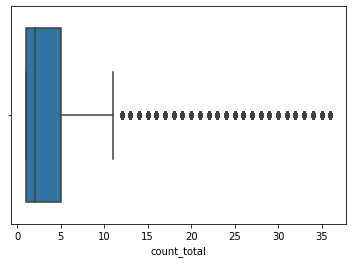

In [134]:
sns.boxplot(x=featuresTraining['count_total'])

In order to get a list of identified outlier, we will need to use the mathematical formula IQR and retrieve the outlier data.

In [135]:
Q1 = featuresTraining.quantile(0.04)
Q3 = featuresTraining.quantile(0.96)
IQR = Q3 - Q1
print(IQR)

donorID              41114.200000
count_total             17.000000
count_non_0             16.000000
count_0                  1.000000
sum                    527.214000
Sum_targeted           491.784000
Sum_not_targeted        32.250000
mean                    45.239231
mean_targeted           45.400000
mean_non_targeted       30.066000
time_last_gave        5432.200000
targeted                 0.000000
dtype: float64


In [136]:
Q1 = featuresTest.quantile(0.04)
Q3 = featuresTest.quantile(0.96)
IQR = Q3 - Q1
print(IQR)

donorID              41114.200000
count_total             18.000000
count_non_0             17.000000
count_0                  1.000000
sum                    544.198000
Sum_targeted           508.488000
Sum_not_targeted        35.376000
mean                    46.500000
mean_targeted           45.218667
mean_non_targeted       32.230000
time_last_gave        6011.000000
targeted                 0.000000
dtype: float64


In [137]:
featuresTraining.head()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
0,100001,12,11.0,1.0,178.49,166.10,12.39,14.874167,15.1000,12.39,2936,1
1,100002,1,1.0,0.0,20.00,20.00,0.00,20.000000,20.0000,0.00,1580,1
2,100003,4,4.0,0.0,15.00,15.00,0.00,3.750000,3.7500,0.00,735,1
3,100004,26,25.0,1.0,716.22,691.43,24.79,27.546923,27.6572,24.79,3300,1
4,100005,4,4.0,0.0,14.96,14.96,0.00,3.740000,3.7400,0.00,743,1


In [138]:
(featuresTraining < (Q1 - 1.5 * IQR)) |(featuresTraining > (Q3 + 1.5 * IQR))

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False


In [139]:
(featuresTest < (Q1 - 1.5 * IQR)) |(featuresTest > (Q3 + 1.5 * IQR))

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False


In [140]:
featuresTraining.shape

(44686, 12)

In [141]:
featuresTest.shape

(44686, 12)

In [142]:
featuresTraining = featuresTraining[~((featuresTraining < (Q1 - 1.5 * IQR)) |(featuresTraining > (Q3 + 1.5 * IQR))).any(axis=1)]
featuresTraining.shape

(42027, 12)

In [143]:
featuresTest = featuresTest[~((featuresTest < (Q1 - 1.5 * IQR)) |(featuresTest > (Q3 + 1.5 * IQR))).any(axis=1)]
featuresTest.shape

(41998, 12)

In [144]:
featuresTest.describe()

,donorID,count_total,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
count,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998.0
mean,122486.934735,4.239178,4.141840,0.097338,106.388609,103.872568,2.516041,24.857343,24.866272,2.209539,2764.652912,1.0
std,12839.563253,5.373066,5.281219,0.335248,153.284333,150.575313,9.678488,14.455839,14.529752,8.263609,1729.361964,0.0
min,100001.000000,1.000000,1.000000,0.000000,5.000000,2.480000,0.000000,1.390000,1.390000,0.000000,26.000000,1.0
25%,111452.250000,1.000000,1.000000,0.000000,24.790000,24.790000,0.000000,12.390000,12.390000,0.000000,1479.000000,1.0
50%,122560.500000,2.000000,2.000000,0.000000,49.575000,45.000000,0.000000,25.000000,25.000000,0.000000,2346.000000,1.0
75%,133606.750000,5.000000,5.000000,0.000000,120.967500,119.152500,0.000000,32.500000,32.500000,0.000000,4019.000000,1.0
max,144691.000000,45.000000,43.000000,2.000000,1321.850000,1275.360000,86.760000,116.666667,116.666667,80.000000,7304.000000,1.0


## Data Preparation : Merging donors2, features and campaign in training & test sets

#### We will do a left joing on training / test sets with donors 2 & features

We first do a left join on trainingSet with donors2 on donorID

In [145]:
trainingSetFinal =  pd.merge(trainingSet, donors2, how = "left",
                            left_on = "donorID", right_on = "donorID")

In [146]:
trainingSetFinal.head()

,donorID,amount,target,zipcode,Is__C,Is__M,Is__S,Is__U,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,Is_in__Flandre-Orientale,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur,distance_km
0,100001,0.0,0,1861.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.30
1,100002,0.0,0,2260.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00
2,100004,0.0,0,1020.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.34
3,100008,0.0,0,1780.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.92
4,100009,0.0,0,1020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.34


In [147]:
trainingSetFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34917 entries, 0 to 34916
Data columns (total 20 columns):
donorID                       34917 non-null int64
amount                        34917 non-null float64
target                        34917 non-null int32
zipcode                       34914 non-null float64
Is__C                         34914 non-null float64
Is__M                         34914 non-null float64
Is__S                         34914 non-null float64
Is__U                         34914 non-null float64
Is__French                    34914 non-null float64
Is_in__Brabant Flamand        34914 non-null float64
Is_in__Brabant Wallon         34914 non-null float64
Is_in__Bruxelles              34914 non-null float64
Is_in__Flandre-Occidentale    34914 non-null float64
Is_in__Flandre-Orientale      34914 non-null float64
Is_in__Hainaut                34914 non-null float64
Is_in__Limbourg               34914 non-null float64
Is_in__Liège                  34914 non-null fl

Then we do a left join on the trainingSetFinal that we've just created with features on donorID

In [148]:
trainingSetFinal =  pd.merge(trainingSetFinal, featuresTraining, how = "left",
                            left_on = "donorID", right_on = "donorID")

In [149]:
trainingSetFinal.head()

,donorID,amount,target,zipcode,Is__C,Is__M,Is__S,Is__U,Is__French,Is_in__Brabant Flamand,...,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
0,100001,0.0,0,1861.0,0.0,1.0,0.0,0.0,0.0,1.0,...,11.0,1.0,178.49,166.10,12.39,14.874167,15.100000,12.39,2936.0,1.0
1,100002,0.0,0,2260.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,20.00,20.00,0.00,20.000000,20.000000,0.00,1580.0,1.0
2,100004,0.0,0,1020.0,0.0,1.0,0.0,0.0,0.0,0.0,...,25.0,1.0,716.22,691.43,24.79,27.546923,27.657200,24.79,3300.0,1.0
3,100008,0.0,0,1780.0,0.0,1.0,0.0,0.0,0.0,1.0,...,3.0,0.0,124.37,124.37,0.00,41.456667,41.456667,0.00,3080.0,1.0
4,100009,0.0,0,1020.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,0.0,326.78,326.78,0.00,17.198947,17.198947,0.00,2828.0,1.0


In [150]:
trainingSetFinal.info()
trainingSetFinal[trainingSetFinal["mean"].astype(str)=="None"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34917 entries, 0 to 34916
Data columns (total 31 columns):
donorID                       34917 non-null int64
amount                        34917 non-null float64
target                        34917 non-null int32
zipcode                       34914 non-null float64
Is__C                         34914 non-null float64
Is__M                         34914 non-null float64
Is__S                         34914 non-null float64
Is__U                         34914 non-null float64
Is__French                    34914 non-null float64
Is_in__Brabant Flamand        34914 non-null float64
Is_in__Brabant Wallon         34914 non-null float64
Is_in__Bruxelles              34914 non-null float64
Is_in__Flandre-Occidentale    34914 non-null float64
Is_in__Flandre-Orientale      34914 non-null float64
Is_in__Hainaut                34914 non-null float64
Is_in__Limbourg               34914 non-null float64
Is_in__Liège                  34914 non-null fl

,donorID,amount,target,zipcode,Is__C,Is__M,Is__S,Is__U,Is__French,Is_in__Brabant Flamand,...,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted


Now, we do the same for the testSet

In [151]:
testSetFinal =  pd.merge(testSet, donors2, how = "left",
                            left_on = "donorID", right_on = "donorID")

In [152]:
testSetFinal.head()

,donorID,amount,target,zipcode,Is__C,Is__M,Is__S,Is__U,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,Is_in__Flandre-Orientale,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur,distance_km
0,100001,0.0,0,1861.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.30
1,100002,0.0,0,2260.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00
2,100008,0.0,0,1780.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.92
3,100009,0.0,0,1020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.34
4,100010,0.0,0,1020.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.34


In [153]:
testSetFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 20 columns):
donorID                       25645 non-null int64
amount                        25645 non-null float64
target                        25645 non-null int32
zipcode                       25644 non-null float64
Is__C                         25644 non-null float64
Is__M                         25644 non-null float64
Is__S                         25644 non-null float64
Is__U                         25644 non-null float64
Is__French                    25644 non-null float64
Is_in__Brabant Flamand        25644 non-null float64
Is_in__Brabant Wallon         25644 non-null float64
Is_in__Bruxelles              25644 non-null float64
Is_in__Flandre-Occidentale    25644 non-null float64
Is_in__Flandre-Orientale      25644 non-null float64
Is_in__Hainaut                25644 non-null float64
Is_in__Limbourg               25644 non-null float64
Is_in__Liège                  25644 non-null fl

And now we do again a left join for testSetFinal on features

In [154]:
testSetFinal =  pd.merge(testSetFinal, featuresTest, how = "left",
                            left_on = "donorID", right_on = "donorID")

In [155]:
testSetFinal.head()

,donorID,amount,target,zipcode,Is__C,Is__M,Is__S,Is__U,Is__French,Is_in__Brabant Flamand,...,count_non_0,count_0,sum,Sum_targeted,Sum_not_targeted,mean,mean_targeted,mean_non_targeted,time_last_gave,targeted
0,100001,0.0,0,1861.0,0.0,1.0,0.0,0.0,0.0,1.0,...,11.0,1.0,178.49,166.10,12.39,14.874167,15.100000,12.39,2936.0,1.0
1,100002,0.0,0,2260.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,20.00,20.00,0.00,20.000000,20.000000,0.00,1580.0,1.0
2,100008,0.0,0,1780.0,0.0,1.0,0.0,0.0,0.0,1.0,...,3.0,0.0,124.37,124.37,0.00,41.456667,41.456667,0.00,3080.0,1.0
3,100009,0.0,0,1020.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,0.0,326.78,326.78,0.00,17.198947,17.198947,0.00,2828.0,1.0
4,100010,0.0,0,1020.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,40.00,40.00,0.00,40.000000,40.000000,0.00,1642.0,1.0


In [156]:
testSetFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 31 columns):
donorID                       25645 non-null int64
amount                        25645 non-null float64
target                        25645 non-null int32
zipcode                       25644 non-null float64
Is__C                         25644 non-null float64
Is__M                         25644 non-null float64
Is__S                         25644 non-null float64
Is__U                         25644 non-null float64
Is__French                    25644 non-null float64
Is_in__Brabant Flamand        25644 non-null float64
Is_in__Brabant Wallon         25644 non-null float64
Is_in__Bruxelles              25644 non-null float64
Is_in__Flandre-Occidentale    25644 non-null float64
Is_in__Flandre-Orientale      25644 non-null float64
Is_in__Hainaut                25644 non-null float64
Is_in__Limbourg               25644 non-null float64
Is_in__Liège                  25644 non-null fl

We check if there is some missing values due to the double join that we've done

In [157]:
trainingSetFinal.isna().sum()

donorID                          0
amount                           0
target                           0
zipcode                          3
Is__C                            3
Is__M                            3
Is__S                            3
Is__U                            3
Is__French                       3
Is_in__Brabant Flamand           3
Is_in__Brabant Wallon            3
Is_in__Bruxelles                 3
Is_in__Flandre-Occidentale       3
Is_in__Flandre-Orientale         3
Is_in__Hainaut                   3
Is_in__Limbourg                  3
Is_in__Liège                     3
Is_in__Luxembourg                3
Is_in__Namur                     3
distance_km                      3
count_total                   2085
count_non_0                   2085
count_0                       2085
sum                           2085
Sum_targeted                  2085
Sum_not_targeted              2085
mean                          2085
mean_targeted                 2085
mean_non_targeted   

We replace the missing values with 0 to make sure that our alogirithms will be able to work

In [158]:
trainingSetFinal = trainingSetFinal.replace({np.nan: 0})

In [159]:
trainingSetFinal.isna().sum()

donorID                       0
amount                        0
target                        0
zipcode                       0
Is__C                         0
Is__M                         0
Is__S                         0
Is__U                         0
Is__French                    0
Is_in__Brabant Flamand        0
Is_in__Brabant Wallon         0
Is_in__Bruxelles              0
Is_in__Flandre-Occidentale    0
Is_in__Flandre-Orientale      0
Is_in__Hainaut                0
Is_in__Limbourg               0
Is_in__Liège                  0
Is_in__Luxembourg             0
Is_in__Namur                  0
distance_km                   0
count_total                   0
count_non_0                   0
count_0                       0
sum                           0
Sum_targeted                  0
Sum_not_targeted              0
mean                          0
mean_targeted                 0
mean_non_targeted             0
time_last_gave                0
targeted                      0
dtype: i

We see that's fixed now

In [160]:
testSetFinal.isna().sum()

donorID                          0
amount                           0
target                           0
zipcode                          1
Is__C                            1
Is__M                            1
Is__S                            1
Is__U                            1
Is__French                       1
Is_in__Brabant Flamand           1
Is_in__Brabant Wallon            1
Is_in__Bruxelles                 1
Is_in__Flandre-Occidentale       1
Is_in__Flandre-Orientale         1
Is_in__Hainaut                   1
Is_in__Limbourg                  1
Is_in__Liège                     1
Is_in__Luxembourg                1
Is_in__Namur                     1
distance_km                      1
count_total                   1536
count_non_0                   1536
count_0                       1536
sum                           1536
Sum_targeted                  1536
Sum_not_targeted              1536
mean                          1536
mean_targeted                 1536
mean_non_targeted   

We do the same with the testSet

In [161]:
testSetFinal = testSetFinal.replace({np.nan: 0})


In [162]:
testSetFinal.isna().sum()

donorID                       0
amount                        0
target                        0
zipcode                       0
Is__C                         0
Is__M                         0
Is__S                         0
Is__U                         0
Is__French                    0
Is_in__Brabant Flamand        0
Is_in__Brabant Wallon         0
Is_in__Bruxelles              0
Is_in__Flandre-Occidentale    0
Is_in__Flandre-Orientale      0
Is_in__Hainaut                0
Is_in__Limbourg               0
Is_in__Liège                  0
Is_in__Luxembourg             0
Is_in__Namur                  0
distance_km                   0
count_total                   0
count_non_0                   0
count_0                       0
sum                           0
Sum_targeted                  0
Sum_not_targeted              0
mean                          0
mean_targeted                 0
mean_non_targeted             0
time_last_gave                0
targeted                      0
dtype: i

And here it's fixed too

## Model building

#### Note: We tried to design this part to be an automatized part. It means that if you change variables, add algorithms or change the data which will lead to make that one algorithm will not be anymore efficient as it used to be, the following code will only select the best algorithms automatically without any needed change. This is why we're using a lot of differents variables. 

#### We've now finished to clean & prepare the data, we're now going to build the model 

First, we need to create a validation set, to do this we will divide the trainingSetFinal into a trainingSetFinal2 and a ValidationSet. We add a seed to make sure to be able to create the same trainingSet to compare for all actions we've impletemend if it was increasing the AUC or not.

In [163]:
np.random.seed(1)
partitions = partition(dataFrame = trainingSetFinal, splitStrategy = [0.75,0.25])

In [164]:
for (index,dataFrame) in enumerate(partitions):
    print(f"Partition {index} shape : {dataFrame.shape} ({len(dataFrame)/len(trainingSetFinal)})")

Partition 0 shape : (26188, 31) (0.7500071598361829)
Partition 1 shape : (8729, 31) (0.24999284016381706)


In [165]:
trainingSetFinal2   = partitions[0]
validationSetFinal = partitions[1]

#### Then, we will create an algorithm to select the relevant variable 

Our selectedFeatures are all of our features except donorID because it's our key, target because it's what we're looking for and amount because we created the target from the amount so keeping this will lead to 100% accuracy and for the future, we won't obviously have before we send the campaign how much they gave.

In [166]:
selectedFeatures = []
target = "target"

for col in trainingSetFinal2.columns:
        if col not in ("donorID", "target","amount"):
            selectedFeatures.append(col)

In [167]:
print(selectedFeatures)

['zipcode', 'Is__C', 'Is__M', 'Is__S', 'Is__U', 'Is__French', 'Is_in__Brabant Flamand', 'Is_in__Brabant Wallon', 'Is_in__Bruxelles', 'Is_in__Flandre-Occidentale', 'Is_in__Flandre-Orientale', 'Is_in__Hainaut', 'Is_in__Limbourg', 'Is_in__Liège', 'Is_in__Luxembourg', 'Is_in__Namur', 'distance_km', 'count_total', 'count_non_0', 'count_0', 'sum', 'Sum_targeted', 'Sum_not_targeted', 'mean', 'mean_targeted', 'mean_non_targeted', 'time_last_gave', 'targeted']


Now, we initialize all the type of algorithms we want to use to predict our target

In [168]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

We create a dictionnary models which contains the reference to all algorithms, we will use this to loop over all algorithms

In [169]:
models = {"tree"         :tree,
            "logistic"     :logistic,
            "randomForest" :randomForest,
            "boostedTree"  :boostedTree,
             "svm"          :svm,
             "neuralNet"    :neuralNet,
             "neighbors"    :neighbors
               
         }

In [170]:
for model_tested in models:
        print(model_tested)

tree
logistic
randomForest
boostedTree
svm
neuralNet
neighbors


Now, we create a stepwise function: 
This function is used to define a lot of things. First, it will loop over all algorithms. For each algorithms, it will loop over all variables that we defined before in selectedFeatures, and for each, will assign them an AUC score. After, it will go over the second, third ect.. for each algorithms in order to create all possible combinaisons of variables in selectedFeatures.
For each of the combinaison, it will return au AUC score. It's going to do this for each algorithm so it's a long function which take more than one hour. The goal of this function is to define for each algorithm, the best combinaisons of variable to use. 
We use the trainingSetfinal2 to train our different models and the validationSetFinal to have the AUC score which we're going to use to define which combinaison is the best for each algorithm.

In [171]:
def stepwiseRegresion (trainingSet: pd.DataFrame, testSet: pd.DataFrame, selectedFeatures: [str], target: [str]) -> pd.DataFrame:
    forwardSelection = []
    
    for model_tested in models:
        print(model_tested)
        def computeAUC (forFeatures: [str]) -> ([str],float,float):
    
            models[model_tested].fit(trainingSetFinal2[forFeatures], trainingSetFinal2[target])

            trainingSetFinal2["proba donate 35€"] = pd.DataFrame(models[model_tested].predict_proba(trainingSetFinal2[forFeatures]))[1]
            validationSetFinal["proba donate 35€"]     = pd.DataFrame(models[model_tested].predict_proba(validationSetFinal[forFeatures]))[1]

            aucTraining = roc_auc_score(pd.array(trainingSetFinal2[target]),pd.array(trainingSetFinal2["proba donate 35€"]))
            aucTest     = roc_auc_score(pd.array(validationSetFinal[target]),pd.array(validationSetFinal["proba donate 35€"]))

            trainingSetFinal2.drop("proba donate 35€", axis = 1)
            validationSetFinal.drop("proba donate 35€", axis = 1)

            return (forFeatures,aucTraining,aucTest)

        featuresOrder = []

        for step in range(len(selectedFeatures)):
            print(f"step {step+1}")
            aucs = []
            for feature in selectedFeatures:
                if feature not in featuresOrder:
                    modelFeatures = featuresOrder.copy()
                    modelFeatures.append(feature)
                    aucs.append(computeAUC(forFeatures = modelFeatures))
                

            steps = pd.DataFrame(aucs)
            steps.columns = ["Feature","AUC training", "AUC test"]
            steps = steps.sort_values(by=["AUC test"], ascending = False)

            featuresOrder = steps["Feature"].iloc[0]
            forwardSelection.append((model_tested, step +1, steps["Feature"].iloc[0],steps["AUC training"].iloc[0],steps["AUC test"].iloc[0]))

        df = pd.DataFrame(forwardSelection)
        df.columns = ("Model","Step","Features","AUC Train","AUC ValidationSet")
    return df
   

In [172]:
forwardSelection = stepwiseRegresion(trainingSet      = trainingSetFinal2, 
                                     testSet          = validationSetFinal, 
                                     selectedFeatures = selectedFeatures,
                                     target           = target)


tree
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
logistic
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


step 12


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 13


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 14


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 15


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 16


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 17


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 18


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 19


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 20


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 21


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 22


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 23


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 24


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

step 25


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


step 26


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


step 27


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


step 28
randomForest
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
boostedTree
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
svm
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
neuralNet
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
neighbors
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step

In [173]:
forwardSelection

,Model,Step,Features,AUC Train,AUC ValidationSet
0,tree,1,[Is__C],0.512576,0.552095
1,tree,2,"[Is__C, Is__M]",0.527999,0.590191
2,tree,3,"[Is__C, Is__M, Is__U]",0.531555,0.594319
3,tree,4,"[Is__C, Is__M, Is__U, Is__S]",0.535670,0.597840
4,tree,5,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg]",0.543910,0.601660
5,tree,6,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg, ...",0.547696,0.605456
6,tree,7,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg, ...",0.553703,0.608084
7,tree,8,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg, ...",0.556808,0.611742
8,tree,9,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg, ...",0.569382,0.614862
9,tree,10,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg, ...",0.570108,0.618081


We see that it's a huge dataset with all combinaisons for our differents algorithms.

Now, we use the code bellow to choose the highest AUC Score for the validation test for each algorithm and we assign the row with the higher AUC Score to our previous dataset.

In [174]:
forwardSelection = forwardSelection.loc[forwardSelection.groupby('Model')['AUC ValidationSet'].idxmax()]

Now, if we look at the dataset, it's only the number of rows representing the number of differents algorithms we inputed with the combinaison which lead to the highest AUC Score on validationSetFinal

In [175]:
forwardSelection

,Model,Step,Features,AUC Train,AUC ValidationSet
92,boostedTree,9,"[mean_targeted, time_last_gave, Is__U, targete...",0.788345,0.700677
44,logistic,17,"[mean, Is__C, targeted, Is__U, Sum_targeted, I...",0.651833,0.679454
177,neighbors,10,"[mean_targeted, Is_in__Liège, Sum_not_targeted...",0.728520,0.557887
147,neuralNet,8,"[mean, Is__C, Is__S, mean_targeted, Is__U, Sum...",0.677511,0.698226
70,randomForest,15,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg, ...",0.612923,0.616865
119,svm,8,"[mean, Is__French, count_0, targeted, Is__C, I...",0.637048,0.653428
11,tree,12,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg, ...",0.572963,0.618942


We're now going to sort the values in the dataset we've created by name of algorithm, it will be usefull because it's sorted by character and bellow we're going to define a models dictionnary which refers to the algorithms in the same order. We make this to make sure that we're going to use the right combinaison for the right algorithm and don't use the best combinaison of one algorithm for another one because of an unsorted dataSet.

In [176]:
BestVars = forwardSelection

In [177]:
BestVars = BestVars.sort_values(by=['Model'],ascending=False)


In [178]:
BestVars.head(10)

,Model,Step,Features,AUC Train,AUC ValidationSet
11,tree,12,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg, ...",0.572963,0.618942
119,svm,8,"[mean, Is__French, count_0, targeted, Is__C, I...",0.637048,0.653428
70,randomForest,15,"[Is__C, Is__M, Is__U, Is__S, Is_in__Limbourg, ...",0.612923,0.616865
147,neuralNet,8,"[mean, Is__C, Is__S, mean_targeted, Is__U, Sum...",0.677511,0.698226
177,neighbors,10,"[mean_targeted, Is_in__Liège, Sum_not_targeted...",0.728520,0.557887
44,logistic,17,"[mean, Is__C, targeted, Is__U, Sum_targeted, I...",0.651833,0.679454
92,boostedTree,9,"[mean_targeted, time_last_gave, Is__U, targete...",0.788345,0.700677


Now, we create an empty BestFeatures, inside we will input the combinaisons of each algorithms. We will use this as our features for the prediction of each algorithm.

In [179]:
BestFeatures = []

In [180]:
for col in BestVars['Features']:
        print(col)
        if col not in ("donorID", "target","amount"):
            BestFeatures.append(col)

['Is__C', 'Is__M', 'Is__U', 'Is__S', 'Is_in__Limbourg', 'Is_in__Brabant Wallon', 'Is_in__Bruxelles', 'Is_in__Flandre-Occidentale', 'Is__French', 'Is_in__Namur', 'Is_in__Luxembourg', 'Is_in__Hainaut']
['mean', 'Is__French', 'count_0', 'targeted', 'Is__C', 'Is_in__Namur', 'Is_in__Limbourg', 'Is__U']
['Is__C', 'Is__M', 'Is__U', 'Is__S', 'Is_in__Limbourg', 'Is_in__Brabant Wallon', 'Is_in__Flandre-Occidentale', 'Sum_not_targeted', 'targeted', 'Is_in__Bruxelles', 'mean_non_targeted', 'Is__French', 'Is_in__Hainaut', 'Is_in__Namur', 'count_0']
['mean', 'Is__C', 'Is__S', 'mean_targeted', 'Is__U', 'Sum_not_targeted', 'Is_in__Brabant Flamand', 'targeted']
['mean_targeted', 'Is_in__Liège', 'Sum_not_targeted', 'Is_in__Flandre-Orientale', 'Is_in__Brabant Wallon', 'targeted', 'Is_in__Brabant Flamand', 'Is__U', 'Is_in__Luxembourg', 'Is_in__Bruxelles']
['mean', 'Is__C', 'targeted', 'Is__U', 'Sum_targeted', 'Is__M', 'Is_in__Brabant Wallon', 'Is_in__Brabant Flamand', 'Is_in__Flandre-Occidentale', 'Sum_no

Now, we've BestFeatures with all the combinaisons and only the combinaisons so we will be able to input for each algorithm, the best variable that he needed to predict the best.

In [181]:
BestFeatures[0]

['Is__C',
 'Is__M',
 'Is__U',
 'Is__S',
 'Is_in__Limbourg',
 'Is_in__Brabant Wallon',
 'Is_in__Bruxelles',
 'Is_in__Flandre-Occidentale',
 'Is__French',
 'Is_in__Namur',
 'Is_in__Luxembourg',
 'Is_in__Hainaut']

#### Now, we will initate differents algorithms models and select the best one now that we've the features 

#### Now that we've the features and the target, we instanciate the models

In [182]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

As explained above, this dictionnary with models is created in an alphabetic order to corresponds to the sort we've done before so now BestFeatures has the right corresponding variable of each algorithm.

In [183]:
models ={"tree"         :tree,
         "svm"          :svm,
         "randomForest" :randomForest,
         "neuralNet"    :neuralNet,
         "neighbors"    :neighbors,
         "logistic"     :logistic,
         "boostedTree"  :boostedTree,
         }

#### We now train models on the trainingSet

We inputed BestFeatures[i] and i = 0 so in the first iteration of the loop, it will search for the first model in models and the first variable in BestFeatures so they correspond to the model we're fiting. And with the loop, we do this for each algorithm with the variable that make them predict the best as defined before.

In [184]:
i = 0
for model in models:
    models[model].fit(trainingSetFinal2[BestFeatures[i]],trainingSetFinal2[target])
    print(f"{model} has been trained successfully")
    print(BestFeatures[i])
    i = i+1

tree has been trained successfully
['Is__C', 'Is__M', 'Is__U', 'Is__S', 'Is_in__Limbourg', 'Is_in__Brabant Wallon', 'Is_in__Bruxelles', 'Is_in__Flandre-Occidentale', 'Is__French', 'Is_in__Namur', 'Is_in__Luxembourg', 'Is_in__Hainaut']
svm has been trained successfully
['mean', 'Is__French', 'count_0', 'targeted', 'Is__C', 'Is_in__Namur', 'Is_in__Limbourg', 'Is__U']
randomForest has been trained successfully
['Is__C', 'Is__M', 'Is__U', 'Is__S', 'Is_in__Limbourg', 'Is_in__Brabant Wallon', 'Is_in__Flandre-Occidentale', 'Sum_not_targeted', 'targeted', 'Is_in__Bruxelles', 'mean_non_targeted', 'Is__French', 'Is_in__Hainaut', 'Is_in__Namur', 'count_0']
neuralNet has been trained successfully
['mean', 'Is__C', 'Is__S', 'mean_targeted', 'Is__U', 'Sum_not_targeted', 'Is_in__Brabant Flamand', 'targeted']
neighbors has been trained successfully
['mean_targeted', 'Is_in__Liège', 'Sum_not_targeted', 'Is_in__Flandre-Orientale', 'Is_in__Brabant Wallon', 'targeted', 'Is_in__Brabant Flamand', 'Is__U', '

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


logistic has been trained successfully
['mean', 'Is__C', 'targeted', 'Is__U', 'Sum_targeted', 'Is__M', 'Is_in__Brabant Wallon', 'Is_in__Brabant Flamand', 'Is_in__Flandre-Occidentale', 'Sum_not_targeted', 'distance_km', 'mean_non_targeted', 'Is_in__Limbourg', 'Is__S', 'count_non_0', 'count_0', 'Is_in__Liège']
boostedTree has been trained successfully
['mean_targeted', 'time_last_gave', 'Is__U', 'targeted', 'Is_in__Namur', 'Is_in__Brabant Flamand', 'Is_in__Brabant Wallon', 'Is__C', 'Is_in__Flandre-Occidentale']


In [185]:
BestFeatures[0]

['Is__C',
 'Is__M',
 'Is__U',
 'Is__S',
 'Is_in__Limbourg',
 'Is_in__Brabant Wallon',
 'Is_in__Bruxelles',
 'Is_in__Flandre-Occidentale',
 'Is__French',
 'Is_in__Namur',
 'Is_in__Luxembourg',
 'Is_in__Hainaut']

Now, we compute the performance of each algorithm to be able after to see which one has the best AUC Score on the validationSetFinal with the best variables he could use.

In [186]:
performances = {}
i = 0
for model in models:
    predictions   = models[model].predict(validationSetFinal[BestFeatures[i]])
    probabilities = pd.DataFrame(models[model].predict_proba(validationSetFinal[BestFeatures[i]]))[1]
    accuracy      = accuracy_score(validationSetFinal[target],predictions)
    auc           = roc_auc_score(pd.array(validationSetFinal[target]),pd.array(probabilities))
    i = i +1
    performances[model] = {"Accuracy":accuracy,"AUC":auc}
    
dfValidationSet = pd.DataFrame(performances)

We inspect now the dataframe we've created to see the AUC Score and accuracy of each algorithm

In [187]:
dfValidationSet

,tree,svm,randomForest,neuralNet,neighbors,logistic,boostedTree
AUC,0.618942,0.346572,0.608434,0.671013,0.557887,0.679454,0.700677
Accuracy,0.985680,0.985680,0.985680,0.985680,0.985680,0.985680,0.985451


In [188]:
performances = {}
i = 0
for model in models:
    predictions   = models[model].predict(testSetFinal[BestFeatures[i]])
    probabilities = pd.DataFrame(models[model].predict_proba(testSetFinal[BestFeatures[i]]))[1]
    accuracy      = accuracy_score(testSetFinal[target],predictions)
    auc           = roc_auc_score(pd.array(testSetFinal[target]),pd.array(probabilities))
    i = i +1
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}
dftestSet =pd.DataFrame(performances)

Now we check the performance on the testSet with the best features for each algorithm.

In [189]:
dftestSet

,tree,svm,randomForest,neuralNet,neighbors,logistic,boostedTree
AUC,0.533457,0.351187,0.540778,0.646200,0.525470,0.667674,0.683313
Accuracy,0.994073,0.994073,0.994034,0.994073,0.993917,0.994073,0.993917


### Test Average

We want to be sure that luck isn't part of the score, so we're going to do a loop on the partitions to partition the data few times and train our model with the best features on it, and after to compute the AUC and accuracy. This will help us to avoid luck and by doing more iterations with every time different partition, to have an average and a better overview of our models performance.

In [190]:
performances = {}
score_average = []
for x in range(1,11):
    i = 0
    np.random.seed(1)
    partitions = partition(dataFrame = trainingSetFinal, splitStrategy = [0.75,0.25])
    trainingSetFinal2   = partitions[0]
    validationSetFinal = partitions[1]
    for model in models:
        models[model].fit(trainingSetFinal2[BestFeatures[i]],trainingSetFinal2[target])
        predictions   = models[model].predict(testSetFinal[BestFeatures[i]])
        probabilities = pd.DataFrame(models[model].predict_proba(testSetFinal[BestFeatures[i]]))[1]
        accuracy      = accuracy_score(testSetFinal[target],predictions)
        auc           = roc_auc_score(pd.array(testSetFinal[target]),pd.array(probabilities))
        i = i + 1
        performances[model] = {"Accuracy":accuracy,"AUC":auc}
        score_average.append((model, auc, accuracy))
        
    print("The models were trained on the iteration " + str(x))

score_average = pd.DataFrame(score_average)
score_average.columns = ("Model","AUC","accuracy")


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The models were trained on the iteration 10


We now have a data set with score for every iteration, we now do an average by model to have a better idea of our models performance.

In [191]:
score_avg_final = score_average.groupby('Model').mean()

We now can see which model is the best in average.

In [192]:
score_avg_final

,AUC,accuracy
Model,,
boostedTree,0.683313,0.993917
logistic,0.667674,0.994073
neighbors,0.525470,0.993917
neuralNet,0.623607,0.994073
randomForest,0.549413,0.994034
svm,0.351187,0.994073
tree,0.533457,0.994073


We will transpose this dataframe and sort it the same way as the previous performances results above to make it easier to compare if needed.

In [193]:
score_avg_final = score_avg_final.transpose()

In [194]:
score_avg_final = score_avg_final[score_avg_final.columns[::-1]]

In [195]:
score_avg_final

Model,tree,svm,randomForest,neuralNet,neighbors,logistic,boostedTree
AUC,0.533457,0.351187,0.549413,0.623607,0.525470,0.667674,0.683313
accuracy,0.994073,0.994073,0.994034,0.994073,0.993917,0.994073,0.993917


Now, we want to get the maximum AUC of all the models to after be able to do a bagging on only algorithms with the best AUC.

In [196]:
max_AUC = score_avg_final.loc['AUC'].max()

We now define in a new dataframe that only the algorithms with at most 10% lower in AUC than the best model are selected.

In [197]:
bestAlgorithms = score_avg_final[score_avg_final > max_AUC*0.9]

In [198]:
bestAlgorithms

Model,tree,svm,randomForest,neuralNet,neighbors,logistic,boostedTree
AUC,NaN,NaN,NaN,0.623607,NaN,0.667674,0.683313
accuracy,0.994073,0.994073,0.994034,0.994073,0.993917,0.994073,0.993917


Now we only select the AUC line because accuracy isn't useful in our case.

In [199]:
bestAlgorithms = bestAlgorithms.loc['AUC']

We drop NaN value which corresponds to algorithm with lower score than 90% of the best AUC score.

In [200]:
bestAlgorithms = bestAlgorithms.dropna()

We transform our new variable in a dataFrame.

In [201]:
bestAlgorithms = pd.DataFrame(bestAlgorithms)

In [202]:
bestAlgorithms

,AUC
Model,
neuralNet,0.623607
logistic,0.667674
boostedTree,0.683313


Now, we create a new array with only the name of the algorithm selected before, it will be usefull to assign them to the dictionnary of the models we already created.

In [203]:
bestAlgorithmsName = []

In [204]:
bestAlgorithmsName  = bestAlgorithms.index

In [205]:
bestAlgorithmsName

Index(['neuralNet', 'logistic', 'boostedTree'], dtype='object', name='Model')

In [206]:
for i in bestAlgorithmsName:
    print(i)

neuralNet
logistic
boostedTree


Below, our dictionnary with all the models defined before, we want to change this dictionnary to a new one with only the algorithms selected before with the best AUC.

In [207]:
models

{'tree': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'svm': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 'randomForest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                     

We use this code to create a new dictionnary with only the value existing in the array we define before based on the models dictionnary.

In [208]:
models2 = {k: models[k] for k in (bestAlgorithmsName)}


In [209]:
models2

{'neuralNet': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=200, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 'logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=500,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'boostedTree': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='devia

If you remember, we already defined the best variable for each algorithm in BestVars, such as before we want to only get the features for the best algorithms we selected.

In [210]:
bestVarsAlgorithms = []
algorithmsDF = pd.DataFrame()
for i in range(len(bestAlgorithmsName)):
    bestVarsAlgorithms = (BestVars.loc[BestVars['Model']==bestAlgorithmsName[i]])
    algorithmsDF = algorithmsDF.append(bestVarsAlgorithms)

In [211]:
algorithmsDF

,Model,Step,Features,AUC Train,AUC ValidationSet
147,neuralNet,8,"[mean, Is__C, Is__S, mean_targeted, Is__U, Sum...",0.677511,0.698226
44,logistic,17,"[mean, Is__C, targeted, Is__U, Sum_targeted, I...",0.651833,0.679454
92,boostedTree,9,"[mean_targeted, time_last_gave, Is__U, targete...",0.788345,0.700677


Now that we only have the lines we wanted, we only select the features and we append them into finalFeature which will be the features used for the best algorithms and which correspond for each algorithm selected to their best features.

In [212]:
finalFeatures = []
for col in algorithmsDF['Features']:
        print(col)
        if col not in ("donorID", "target","amount"):
            finalFeatures.append(col)

['mean', 'Is__C', 'Is__S', 'mean_targeted', 'Is__U', 'Sum_not_targeted', 'Is_in__Brabant Flamand', 'targeted']
['mean', 'Is__C', 'targeted', 'Is__U', 'Sum_targeted', 'Is__M', 'Is_in__Brabant Wallon', 'Is_in__Brabant Flamand', 'Is_in__Flandre-Occidentale', 'Sum_not_targeted', 'distance_km', 'mean_non_targeted', 'Is_in__Limbourg', 'Is__S', 'count_non_0', 'count_0', 'Is_in__Liège']
['mean_targeted', 'time_last_gave', 'Is__U', 'targeted', 'Is_in__Namur', 'Is_in__Brabant Flamand', 'Is_in__Brabant Wallon', 'Is__C', 'Is_in__Flandre-Occidentale']


In [213]:
finalFeatures

[['mean',
  'Is__C',
  'Is__S',
  'mean_targeted',
  'Is__U',
  'Sum_not_targeted',
  'Is_in__Brabant Flamand',
  'targeted'],
 ['mean',
  'Is__C',
  'targeted',
  'Is__U',
  'Sum_targeted',
  'Is__M',
  'Is_in__Brabant Wallon',
  'Is_in__Brabant Flamand',
  'Is_in__Flandre-Occidentale',
  'Sum_not_targeted',
  'distance_km',
  'mean_non_targeted',
  'Is_in__Limbourg',
  'Is__S',
  'count_non_0',
  'count_0',
  'Is_in__Liège'],
 ['mean_targeted',
  'time_last_gave',
  'Is__U',
  'targeted',
  'Is_in__Namur',
  'Is_in__Brabant Flamand',
  'Is_in__Brabant Wallon',
  'Is__C',
  'Is_in__Flandre-Occidentale']]

In [214]:
models2

{'neuralNet': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=200, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 'logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=500,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'boostedTree': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='devia

#### Now, we're going to plot for each algorithm the lift curve, cumulative response and cumulative gains

We only do this for the best algorithms because we're going to do a bagging on the probability and that's why before we selected only the best algorithms in order to do the best bagging and to don't take into account algorithms with poor performances for this case.

In [215]:
lifts     = {}
responses = {}
gains     = {}
data      = pd.DataFrame(testSetFinal[target]).copy() 
i = 0
for (index,model) in enumerate(models2):
    data[f"proba {model}"] = pd.DataFrame(models2[model].predict_proba(testSetFinal[finalFeatures[i]]))[1]
    lifts[model] = lift(dataSet = data, actuals = "target", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "target", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "target", probability = "proba "+str(model))
    i = i+1

/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  internalSet["Bin"] = 0
/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  internalSet["Bin"] = 0
/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [216]:
data.head(20)

,target,proba neuralNet,proba logistic,proba boostedTree
0,0,0.004669,0.011864,0.004272
1,0,0.011910,0.013069,0.010672
2,0,0.014383,0.023968,0.015586
3,0,0.009397,0.012283,0.008943
4,0,0.012979,0.022991,0.022302
5,0,0.002672,0.081303,0.010331
6,0,0.002199,0.009017,0.004779
7,0,0.002199,0.009398,0.005196
8,0,0.017359,0.016520,0.023642
9,0,0.012068,0.013516,0.008812


To do a bagging, we're going to do the average of the probability of each algorithm:

In [217]:
datamean = data.iloc[:,1:(len(bestAlgorithmsName)+1)]

In [218]:
datamean.head()

,proba neuralNet,proba logistic,proba boostedTree
0,0.004669,0.011864,0.004272
1,0.011910,0.013069,0.010672
2,0.014383,0.023968,0.015586
3,0.009397,0.012283,0.008943
4,0.012979,0.022991,0.022302


After creating a subset of data with only the columns we wanted, we now create a new column in the original data with the mean of datamean (columns we wanted):

In [219]:
data['Bagging'] = datamean.mean(numeric_only=True, axis=1)


In [220]:
data.head()

,target,proba neuralNet,proba logistic,proba boostedTree,Bagging
0,0,0.004669,0.011864,0.004272,0.006935
1,0,0.011910,0.013069,0.010672,0.011884
2,0,0.014383,0.023968,0.015586,0.017979
3,0,0.009397,0.012283,0.008943,0.010208
4,0,0.012979,0.022991,0.022302,0.019424


### Bagging for the lifts, responses and gains:

As the lifts, responses and gains are calculated on the probability, we compute them again but this time with the bagging probability column we've just created.

In [221]:
liftsBagging = lift(dataSet = data, actuals = "target", probability = "Bagging")
ResponsesBagging = cumulativeResponse(dataSet = data, actuals = "target", probability = "Bagging")
GainsBagging = cumulativeGains(dataSet = data, actuals = "target", probability = "Bagging")

/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  internalSet["Bin"] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [222]:
ResponsesBagging

,Quantile,Cumulative response,Average response
19,1.00,0.020265,0.005927
18,0.95,0.015595,0.005927
17,0.90,0.014037,0.005927
16,0.85,0.012283,0.005927
15,0.80,0.011073,0.005927
14,0.75,0.010138,0.005927
13,0.70,0.009693,0.005927
12,0.65,0.010041,0.005927
11,0.60,0.009705,0.005927
10,0.55,0.009513,0.005927


In [223]:
GainsBagging

,Quantile,Cumulative gains,Base
19,1.00,0.171053,1.00
18,0.95,0.263158,0.95
17,0.90,0.355263,0.90
16,0.85,0.414474,0.85
15,0.80,0.467105,0.80
14,0.75,0.513158,0.75
13,0.70,0.572368,0.70
12,0.65,0.677632,0.65
11,0.60,0.736842,0.60
10,0.55,0.802632,0.55


In [224]:
liftsBagging

,Quantile,Lift,Base
19,1.00,3.419053,1.0
18,0.95,2.631066,1.0
17,0.90,2.368267,1.0
16,0.85,2.072368,1.0
15,0.80,1.868203,1.0
14,0.75,1.710415,1.0
13,0.70,1.635293,1.0
12,0.65,1.694079,1.0
11,0.60,1.637462,1.0
10,0.55,1.605075,1.0


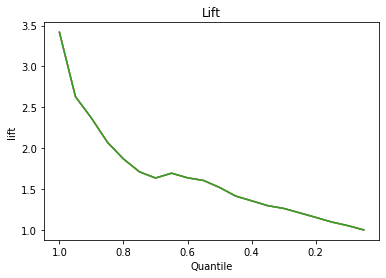

In [225]:
for model in models2:
    pyplot.plot(liftsBagging["Quantile"], liftsBagging["Lift"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("lift")
    pyplot.title("Lift")

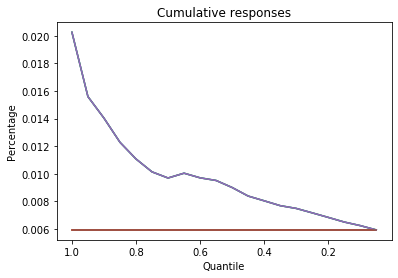

In [226]:
for model in models2:
    pyplot.plot(ResponsesBagging["Quantile"], ResponsesBagging["Cumulative response"])
    pyplot.plot(ResponsesBagging['Quantile'], ResponsesBagging['Average response'])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("Percentage")
    pyplot.title("Cumulative responses")

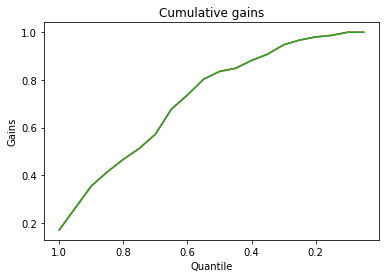

In [227]:
for model in models2:
    pyplot.plot(GainsBagging["Quantile"], GainsBagging["Cumulative gains"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("Gains")
    pyplot.title("Cumulative gains")

## Test Set & Compute AUC

##### Now, we will test our best model on the testSet to have an idea of our AUC score and to see how perform our best model

We select our best algorithm regarding the one has the best AUC score on the average test we've done before with the code below:

In [228]:
maxAUCModel = score_avg_final.loc['AUC'].idxmax(axis=1)

We print the name of the best model

In [229]:
print(maxAUCModel)

boostedTree


Now, such as above, we're going to get back the algorithm which correspond to the models dictionnary we've used above

In [230]:
Model1st = score_avg_final

In [231]:
Model1st = score_avg_final[score_avg_final == max_AUC]


In [232]:
Model1st

Model,tree,svm,randomForest,neuralNet,neighbors,logistic,boostedTree
AUC,NaN,NaN,NaN,NaN,NaN,NaN,0.683313
accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
Model1st = Model1st.loc['AUC']

In [234]:
Model1st = Model1st.dropna()

In [235]:
Model1st  = Model1st.index

In [236]:
print(Model1st)

Index(['boostedTree'], dtype='object', name='Model')


In [237]:
bestModel = {k: models[k] for k in (Model1st)}


In [238]:
bestModel

{'boostedTree': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='auto',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False)}

Now that we have our dictionnary with the best algorithm, we're going to get the best features for this one we defined above:

In [239]:
bestfeaturesAlgorithm = BestVars.loc[BestVars['Model']==Model1st[0]]

In [240]:
firstFeatures = []
for col in bestfeaturesAlgorithm['Features']:
        print(col)
        if col not in ("donorID", "target","amount"):
            firstFeatures.append(col)

['mean_targeted', 'time_last_gave', 'Is__U', 'targeted', 'Is_in__Namur', 'Is_in__Brabant Flamand', 'Is_in__Brabant Wallon', 'Is__C', 'Is_in__Flandre-Occidentale']


In [241]:
firstFeatures

[['mean_targeted',
  'time_last_gave',
  'Is__U',
  'targeted',
  'Is_in__Namur',
  'Is_in__Brabant Flamand',
  'Is_in__Brabant Wallon',
  'Is__C',
  'Is_in__Flandre-Occidentale']]

Now we've the best features for our best algorithm, we just assign to modelFinal the value of the dictionnary bestModel defined before with the best algorithm name.

In [242]:
modelFinal = bestModel[maxAUCModel]

We fit the model on the trainingSetFinal2 using the finalfeatures[0] which corresponds to the best features for this algorithm.

In [243]:
modelFinal.fit(trainingSetFinal2[firstFeatures[0]],trainingSetFinal2[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Now we're doing probabilities and roc to be able to plot the ROC Curve 

In [244]:
trainingSetFinal2["proba donate 35€"] = pd.DataFrame(modelFinal.predict_proba(trainingSetFinal2[firstFeatures[0]]))[1]
testSetFinal["proba donate 35€"] = pd.DataFrame(modelFinal.predict_proba(testSetFinal[firstFeatures[0]]))[1]

In [245]:
rocTrainingFinal = roc(dataSet = trainingSetFinal2, actuals ="target", probability ="proba donate 35€")
rocTestFinal     = roc(dataSet = testSetFinal,     actuals ="target", probability ="proba donate 35€")

### Plot ROC curve

Text(0.5, 1.0, 'Receiver Operating Characteristic Training Set')

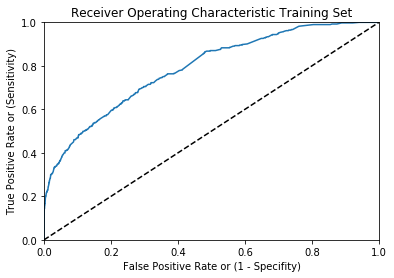

In [246]:
pyplot.plot(rocTrainingFinal["False positive rate"], rocTrainingFinal["True positive rate"])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic Training Set")

Text(0.5, 1.0, 'Receiver Operating Characteristic TestSet')

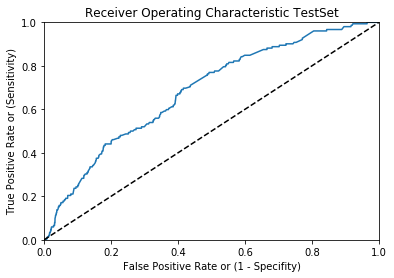

In [247]:
pyplot.plot(rocTestFinal["False positive rate"], rocTestFinal["True positive rate"])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic TestSet")

# Best algorithm AUC

In [248]:
print("The best AUC for the best algorithm: " + str(maxAUCModel) + " is " + str(max_AUC))

The best AUC for the best algorithm: boostedTree is 0.6833128340700336


#### Now we're going to show the variables which have the most importance into the algorithm prediction

In [249]:
firstFeatures[0]

['mean_targeted',
 'time_last_gave',
 'Is__U',
 'targeted',
 'Is_in__Namur',
 'Is_in__Brabant Flamand',
 'Is_in__Brabant Wallon',
 'Is__C',
 'Is_in__Flandre-Occidentale']

In [250]:
importance = pd.DataFrame(boostedTree.feature_importances_)

In [251]:
importance.index = firstFeatures

The following DataFrame contains all the variable and their weight in the algorithm decision

In [252]:
importance

,0
mean_targeted,0.540823
time_last_gave,0.389397
Is__U,0.003478
targeted,0.000691
Is_in__Namur,0.000450
Is_in__Brabant Flamand,0.014632
Is_in__Brabant Wallon,0.003958
Is__C,0.015384
Is_in__Flandre-Occidentale,0.031187


In [253]:
importance = importance.sort_values(by = [0], ascending = False)

Now that we've sorted the data, we can see that variable mean_targeted, time_last_gave and Is_in_Flandre-Occidentale are the top 3 variables witht the most weight.

In [254]:
importance

,0
mean_targeted,0.540823
time_last_gave,0.389397
Is_in__Flandre-Occidentale,0.031187
Is__C,0.015384
Is_in__Brabant Flamand,0.014632
Is_in__Brabant Wallon,0.003958
Is__U,0.003478
targeted,0.000691
Is_in__Namur,0.000450


##### To conclude this code, we're going to print a graphic to show the potential of the campaign to show in which range of people who are more likely to give it's going to make the most profit for the association.

In [255]:
Money = pd.DataFrame()

We take in money the ResponsesBagging Dataframe, we're going to add then a new variable to be able to after do the calcul of rentability.

In [256]:
Money = ResponsesBagging

In [257]:
Money =  Money.reset_index(drop = True)

We reverse the order of Cululative response to make it corresponds for the calcul.

In [258]:
Money["Cumulative response"] = Money["Cumulative response"].values[::-1]

In [259]:
gifts.head()

,campID,donorID,amount,date,today,camp2013_date,Difference_from_2015,Difference_from_camp2013,campaign
0,0,100001,12.39,1998-10-23,2015-01-01,2013-01-04,5914,5187,0
1,1577,100001,12.39,1999-08-18,2015-01-01,2013-01-04,5615,4888,1
2,1634,100001,6.69,1999-12-31,2015-01-01,2013-01-04,5480,4753,1
3,1778,100001,24.79,2000-10-19,2015-01-01,2013-01-04,5187,4460,1
4,1808,100001,7.44,2000-12-29,2015-01-01,2013-01-04,5116,4389,1


We create a new variable which is the average of donation that are at least 35€ per donor.

In [260]:
mean_donation_above_35 = gifts[gifts["amount"] >= 35].groupby(['donorID'])['amount'].mean()

Now, we take the mean of all donation above 35€.

In [261]:
mean_donation_above_35 = mean_donation_above_35.mean()

We assign this value in a new column of Money.

In [262]:
Money['Mean'] = mean_donation_above_35

Now, we calculate the rentability: it's the quantile by 25000 (number of donors in TestSet) by the average of donation that are more than 35€(calculated just above) by the probability to answer. We substract to this the cost of sending letter which is 0.50€ per letter by the quantile by 25000.

In [263]:
Money['Gains evaluated'] = (Money['Quantile'] * Money['Cumulative response'] * 25000 * Money['Mean']) - \
    (Money['Quantile'] * 25000 * 0.50)

We now have in Gains evaluated the gains or loose of money regarding the quantile of people we're going to send the campaign.

In [264]:
Money

,Quantile,Cumulative response,Average response,Mean,Gains evaluated
0,1.00,0.005927,0.005927,54.78355,-4382.336089
1,0.95,0.006239,0.005927,54.78355,-3757.086181
2,0.90,0.006499,0.005927,54.78355,-3238.973911
3,0.85,0.006835,0.005927,54.78355,-2667.461876
4,0.80,0.007165,0.005927,54.78355,-2149.364507
5,0.75,0.007487,0.005927,54.78355,-1684.681516
6,0.70,0.007688,0.005927,54.78355,-1379.810379
7,0.65,0.008039,0.005927,54.78355,-968.531064
8,0.60,0.008384,0.005927,54.78355,-610.666812
9,0.55,0.009004,0.005927,54.78355,-92.598394


We now plot the curve and we can see that for 15% of the donors sorted by the most potential likely donors give us the best rentability on this campaign.

Text(0.5, 1.0, 'Potential gains')

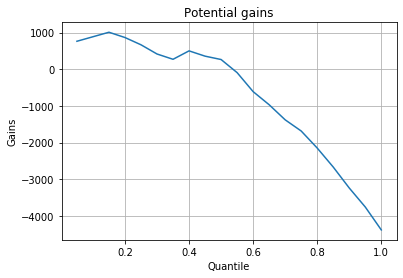

In [265]:
pyplot.plot(Money["Quantile"], Money["Gains evaluated"])
pyplot.grid(True, which='both')
pyplot.xlabel("Quantile")
pyplot.ylabel("Gains")
pyplot.title("Potential gains")

### This was the last step of this prediction assignment, thank you for reading.